# 前言
建议再看一遍电源《泰坦尼克号》，可能会给你一些启发，比如妇女儿童先上船等，所以是否获救其实并非随机，而是基于一些背景有先后顺序的。

# 1. 背景介绍
1912年4月15日，载着1316号乘客和891名船员的豪华巨轮泰坦尼克号在首次航行期间撞上冰山后沉没，2224名乘客和机组人员中有1502人遇难。沉船导致大量伤亡的原因之一是没有足够的救生艇给乘客和船员。虽然幸存下来有一些运气因素，但有一些人比其他人更有可能生存，比如妇女，儿童和上层阶级。在本文中将对哪些人可能生存作出分析，特别是运用Python和机器学习的相关模型工具来预测哪些乘客幸免于难，最后提交结果。

其中，训练和测试数据是一些乘客的个人信息以及存活状况，要尝试根据它生成合适的模型并预测其他人的存活状况。这是一个二分类的问题。

# 2. 数据文件说明
从Kaggle泰坦尼克号项目页面下载数据：https://www.kaggle.com/c/titanic

对于上述变量的说明：
- PassengerID（ID）
- Survived(存活与否)
- Pclass（客舱等级，在当时的英国阶级分层比较严重，较为重要）
- Name（姓名，可提取出更多信息）
- Sex（性别，较为重要）
- Age（年龄，较为重要）
- Parch（直系亲友，是指父母，孩子，其中1表示有一个，依次类推）
- SibSp（旁系，是指兄弟姐妹）
- Ticket（票编号，这个是个玄学问题）
- Fare（票价，可能票价贵的获救几率大）
- Cabin（客舱编号）
- Embarked（上船的港口编号，是指从不同的港口上船）

每个乘客有12个属性，其中，PassengerID在这里只起到索引作用，而Survived是我们要预测的目标，因此我们要处理的数据总共有10个变量。

In [123]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从数据中发现，总数为891个，那还有特征是有空值的，Cabin甚至只有一点数据（不着急，这里我们先看看）。而且有些数据是数值型的，一些是文本型的，还有一些是类目性的。
大概有 0.383838的人最终获救了，平均乘客年龄大概是29.88岁等等。

In [122]:
# Fill age with median
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
# Embarked
titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

In [121]:
import pandas

titanic = pandas.read_csv("/Users/cap/data/titanic/train.csv")

In [103]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.model_selection import KFold


In [105]:
# # The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_splits=3, random_state=1, shuffle=True)

predictions = []
for train, test in kf.split(titanic):
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [106]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.14029180695847362


In [111]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# Initialize our algorithm
alg = LogisticRegression(random_state=1,max_iter=200)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.7946127946127947


In [112]:
titanic_test = pandas.read_csv("/Users/cap/data/titanic/test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

In [113]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
kf = model_selection.KFold(titanic.shape[0], n_splits=3, random_state=1, shuffle=True)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.8069584736251403


In [114]:
alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
kf = model_selection.KFold(titanic.shape[0], n_splits=3, random_state=1, shuffle=True)
scores = model_selection.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.8282828282828283


In [115]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Lady          1
Countess      1
Jonkheer      1
Sir           1
Capt          1
Ms            1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


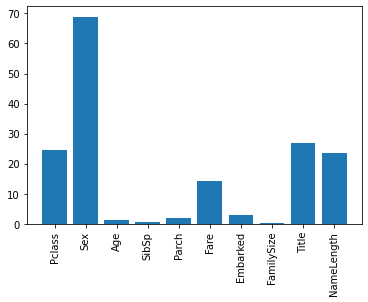

In [116]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "NameLength"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)

In [117]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title",]],
    [LogisticRegression(random_state=1,max_iter=200), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_splits=3, random_state=1, shuffle=True)

predictions = []
for train, test in kf.split(titanic):
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)


0.13692480359147025


In [119]:
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pandas.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [100]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1,max_iter=200), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions

array([0.11603675, 0.47300453, 0.12511163, 0.13057681, 0.51998898,
       0.14410782, 0.63987486, 0.18128421, 0.67801121, 0.12091831,
       0.12061032, 0.21154569, 0.91153109, 0.10806179, 0.89177584,
       0.87819921, 0.16491598, 0.13917736, 0.54000998, 0.55187228,
       0.22447455, 0.53708143, 0.90693218, 0.39533285, 0.88077072,
       0.10285529, 0.91057254, 0.13743394, 0.31382623, 0.12622768,
       0.11607906, 0.18421566, 0.54881314, 0.49382821, 0.42899459,
       0.14225062, 0.5085549 , 0.52452288, 0.13239476, 0.28233455,
       0.1107034 , 0.47244675, 0.09915256, 0.83507153, 0.90025673,
       0.14955007, 0.31895892, 0.13749447, 0.89017572, 0.53809975,
       0.36226886, 0.17952188, 0.83392161, 0.87848669, 0.17773741,
       0.13687091, 0.10597667, 0.12315896, 0.12054873, 0.912202  ,
       0.13130534, 0.15463645, 0.13016598, 0.66596429, 0.66143891,
       0.87353969, 0.67310315, 0.29012002, 0.35830872, 0.84817467,
       0.66219768, 0.12700062, 0.55254144, 0.3738702 , 0.91071